In [297]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import json
from scipy.interpolate import make_interp_spline
from collections import defaultdict
from scipy.interpolate import interp1d


In [3]:
'''
fips
election_type
total_districts
total_represenatives

ensemble summary
    average_seat_share
    average_vote_share


per plan (one out of 5k)
    opportunity_representatives
    opportunity_districts
    dem_vote_share
    rep_vote_share
    total_reprentatives


    demographics
        black
        white
        hispanic
        asian

'''

{}

In [329]:


def election_result_collection(data, json):

    planId = []
    democratsPercentage = []
    republicanPercentage = []
    total_plans = len(json.get("barData", []))
    
    for item in data:
        total_district = len(item.get("ids",{}))
        elec_res = item.get("elec_res", {})

        totals_for_party = elec_res.get("percents_for_party", {})
        dem_totals = totals_for_party.get("Democratic", {})
        rep_totals = totals_for_party.get("Republican", {})

        avg_dem_share = []
        avg_rep_share = []
        dem_seats = 0
        rep_seats = 0

        for district_id in dem_totals:
            #total votes (dem and rep) from the same disctrict (inside the district plan)
  
            total_votes = dem_totals[district_id] + rep_totals.get(district_id, 0)

            if total_votes > 0:
                dem_percentage = dem_totals[district_id] / total_votes * 100
                rep_percentage = rep_totals.get(district_id, 0) / total_votes * 100
            else:
                dem_percentage = 0
                rep_percentage = 0

            avg_dem_share.append(dem_percentage)
            avg_rep_share.append(rep_percentage)

            if dem_percentage > rep_percentage:
                dem_seats += 1
            elif rep_percentage > dem_percentage:
                rep_seats += 1


        total_plans+=1
        planId.append(total_plans)
        dem_share = round(np.mean(avg_dem_share)/100, 2)
        rep_share = round(np.mean(avg_rep_share)/100,2)
        democratsPercentage.append(dem_share)
        republicanPercentage.append(rep_share)
        json["totalDistricts"] = total_district
        json["democratAvgVoteShare"] = (
            json["democratAvgVoteShare"] * (total_plans - 1) + dem_share
        ) / total_plans
        json["republicanAvgVoteShare"] = (
            json["republicanAvgVoteShare"] * (total_plans - 1) + rep_share
        ) / total_plans
        json["democratAvgSeatShare"] = (
            json["democratAvgSeatShare"] * (total_plans - 1) + dem_seats / len(dem_totals)
        ) / total_plans
        json["republicanAvgSeatShare"] = (
            json["republicanAvgSeatShare"] * (total_plans - 1) + rep_seats / len(rep_totals)
        ) / total_plans

 

        
        
      
    ensembles = [ {"planId": v1, "democratsPercentage":v2, "republicanPercentage": v3  }
                for v1 ,v2, v3 in zip(planId, democratsPercentage, republicanPercentage)]
    json["barData"].extend(ensembles) 
def calculate_opportunity_SMD(data, json, minority='hispanic',opportunity_threshold=0.23):

    results = []

    for district_plan in data['barData']:
        plan_id = district_plan['planId']
        opportunity_districts = 0

        for district in district_plan['districts']:
            total_population = district['white'] + district['black'] + district['asian'] + district['hispanic']
            minoirty_population = district[minority]

            minority_proportion = minoirty_population / total_population

            if minority_proportion >= opportunity_threshold:
                opportunity_districts += 1

        for plan in json['barData']:
            if plan['planId'] == plan_id:
                plan['opportunityRepresentatives'] = opportunity_districts  # SMD: 1 rep per district
                plan['opportunityDistricts'] = opportunity_districts
                break
    return results
def collect_ensemble_demographic(data,shapefile ,json):
    i = len(json.get("barData", []))
    planId = []
    white = []
    black = []
    asian = []
    hispanic = []
    for item in data:
    
        districts =  item.get("ids", {})
        demo_summary= {
                    "white": 0,
                    "black": 0,
                    "asian": 0,
                    "hispanic": 0
            }
        for district_id, precinct_ids  in districts.items():
       
            for precinct_id in precinct_ids:
                row = shapefile.iloc[precinct_id]
                demo_summary["white"] += row["WHT"]
                demo_summary["black"] += row["AFAM"]
                demo_summary["asian"] += row["ASN"]
                demo_summary["hispanic"] += row["HPAC"]
        i+=1
        planId.append(i)
        white.append(demo_summary["white"])
        black.append(demo_summary["black"])
        asian.append(demo_summary["asian"])
        hispanic.append(demo_summary["hispanic"])

    ensembles = [ {"planId": v1, "white":v2, "black": v3, "asian": v4, "hispanic": v5  }
                for v1 ,v2, v3, v4, v5 in zip(planId, white, black, asian, hispanic)]
    
    json["barData"].extend(ensembles)                 
def collect_district_plan_demographic(data, shapefile, json):
    i = len(json.get("barData", []))  # Start planId based on existing data

    for item in data:
        districts = item.get("ids", {})
        district_demographics = []

        for district_id, precinct_ids in districts.items():
            
            demo_summary = {
                "districtId": district_id,
                "white": 0,
                "black": 0,
                "asian": 0,
                "hispanic": 0
            }

            
            for precinct_id in precinct_ids:
                row = shapefile.iloc[precinct_id]
                demo_summary["white"] += row["WHT"]
                demo_summary["black"] += row["AFAM"]
                demo_summary["asian"] += row["ASN"]
                demo_summary["hispanic"] += row["HPAC"]

          
            district_demographics.append(demo_summary)

        
        i += 1
        json["barData"].append({
            "planId": i,
            "districts": district_demographics
        })
def collect_vote_seat_share_metrics(data, json):
    planId = []
    demVoteShare = []
    demSeatShare = []
    repSeatShare = []
    repVoteShare = []
    total_plans = len(json.get("barData", []))

    for item in data:
        total_districts = len(item.get("elec_res", {}).get("percents_for_party", {}).get("Democratic", {}))
        elec_res = item.get("elec_res", {})

        totals_for_party = elec_res.get("percents_for_party", {})
        dem_totals = totals_for_party.get("Democratic", {})
        rep_totals = totals_for_party.get("Republican", {})

        dem_seats = 0
        rep_seats = 0

        dem_vote_shares = []
        rep_vote_shares = []

        for district_id in dem_totals:
            dem_vote_share = dem_totals[district_id]
            rep_vote_share = rep_totals.get(district_id, 0)

            dem_vote_shares.append(dem_vote_share)
            rep_vote_shares.append(rep_vote_share)

            if dem_vote_share > rep_vote_share:
                dem_seats += 1
            elif rep_vote_share > dem_vote_share:
                rep_seats += 1

        avg_dem_vote_share = round(sum(dem_vote_shares) / total_districts, 2)
        avg_rep_vote_share = round(sum(rep_vote_shares) / total_districts, 2)
        dem_seat_share = round(dem_seats / total_districts, 2)
        rep_seat_share = round(rep_seats / total_districts, 2)

        
        total_plans += 1
        planId.append(total_plans)
        demVoteShare.append(avg_dem_vote_share)
        repVoteShare.append(avg_rep_vote_share)
        demSeatShare.append(dem_seat_share)
        repSeatShare.append(rep_seat_share)


    ensembles = [ {"planId": v1, "demVoteShare":v2, "demSeatShare": v3 ,"repVoteShare": v4, "repSeatShare": v5  }
                for v1 ,v2, v3 , v4,v5 in zip(planId, demVoteShare , demSeatShare, repVoteShare, repSeatShare)]
    json["barData"].extend(ensembles) 
def calculate_annotation_for_vote_seat_share(data): 
    bias = 0
    symmetry = 0
    responsiveness = 0
    dem_vote_share = np.array([entry['demVoteShare'] for entry in data['barData']])
    dem_seat_share = np.array([entry['demSeatShare'] for entry in data['barData']])

    rep_vote_share = np.array([entry['repVoteShare'] for entry in data['barData']])
    rep_seat_share = np.array([entry['repSeatShare'] for entry in data['barData']])

    # Bias: Difference between seat share at 50% and vote share at 50%
    closest_to_50_index = np.argmin(np.abs(dem_vote_share - 0.50))
    bias = dem_seat_share[closest_to_50_index] - 0.50

    # Responsiveness: Slope around 50% vote share
    if closest_to_50_index > 0 and closest_to_50_index < len(dem_vote_share) - 1:
        delta_vote = dem_vote_share[closest_to_50_index + 1] - dem_vote_share[closest_to_50_index - 1]
        delta_seat = dem_seat_share[closest_to_50_index + 1] - dem_seat_share[closest_to_50_index - 1]
        responsiveness = delta_seat / delta_vote
    else:
        responsiveness = None  # Not enough data

    #Symmetry: Compare seat shares at symmetric vote shares
    symmetric_indices = [
        (i, np.argmin(np.abs(rep_vote_share - (1 - dem_vote_share[i]))))
        for i in range(len(dem_vote_share))
        if np.min(np.abs(rep_vote_share - (1 - dem_vote_share[i]))) < 0.01
        ]
    symmetry_values = [
        dem_seat_share[i] - rep_seat_share[j] for i, j in symmetric_indices
    ]
    symmetry = np.mean(symmetry_values) if symmetry_values else None

    data["bias"] = bias
    data["symmetry"] = symmetry
    data["responsiveness"] = responsiveness
def collect_box_and_whisker(data, json, races):
    total_districts = data["totalDistricts"]  # Use totalDistricts from the data
    districts_data = {f"District {i+1}": {race: [] for race in races} for i in range(total_districts)}

    # Collect data for each race as percentages
    for plan in data['barData']:
        for i, district in enumerate(plan['districts']):
            total_population = sum(district[race] for race in races)  # Calculate total population for the district
            for race in races:
                # Convert race population to percentage
                if total_population > 0:
                    percentage = (district[race] / total_population) * 100
                else:
                    percentage = 0
                districts_data[f"District {i+1}"][race].append(percentage)

    # Calculate statistics for each district and race
    for district, race_values in districts_data.items():
        stats = {"binNo": int(district.split()[-1])}
        for race, values in race_values.items():
            values = np.array(values)
            stats[race] = {
                "min": float(np.min(values)),
                "q1": float(np.percentile(values, 25)),
                "median": float(np.median(values)),
                "q3": float(np.percentile(values, 75)),
                "max": float(np.max(values)),
                "enactedValue": None  # Placeholder for enacted value if needed
            }
        json["boxes"].append(stats)




In [337]:
def aggregate_vote_seat_data(vote_share, seat_share):
    vote_seat_map = defaultdict(list)
    for v, s in zip(vote_share, seat_share):
        vote_seat_map[v].append(s)
    unique_vote_share = list(vote_seat_map.keys())
    averaged_seat_share = [np.mean(vote_seat_map[v]) for v in unique_vote_share]
    return unique_vote_share, averaged_seat_share
def vote_seat_share(data):

    dem_data = sorted([(entry['demVoteShare'], entry['demSeatShare']) for entry in data['barData']], key=lambda x: x[0])
    dem_vote_share, dem_seat_share = zip(*dem_data)
    dem_vote_share, dem_seat_share = aggregate_vote_seat_data(dem_vote_share, dem_seat_share)

   
    rep_data = sorted([(entry['repVoteShare'], entry['repSeatShare']) for entry in data['barData']], key=lambda x: x[0])
    rep_vote_share, rep_seat_share = zip(*rep_data)
    rep_vote_share, rep_seat_share = aggregate_vote_seat_data(rep_vote_share, rep_seat_share)

   
    dem_interpolator = interp1d(dem_vote_share, dem_seat_share, kind='quadratic', fill_value='extrapolate')
    rep_interpolator = interp1d(rep_vote_share, rep_seat_share, kind='quadratic', fill_value='extrapolate')

  
    smooth_x = np.linspace(min(dem_vote_share + rep_vote_share), max(dem_vote_share + rep_vote_share), 500)
    dem_smooth_y = dem_interpolator(smooth_x)
    rep_smooth_y = rep_interpolator(smooth_x)

 
    plt.figure(figsize=(10, 6))


    plt.plot(smooth_x, dem_smooth_y, label="Democrats", color="blue")

  
    plt.plot(smooth_x, rep_smooth_y, label="Republicans", color="red")

    plt.title("SMD Vote/Seat Share Ensemble")
    plt.xlabel("Vote Share")
    plt.ylabel("Seat Share")
    plt.legend()
    plt.grid(True)


    plt.show()
def ensembles_box_and_whisker(data, comparison_basis):
    
    sorted_boxes = sorted(data["boxes"], key=lambda x: x[comparison_basis]["median"])

    bins = [f"District {box['binNo']}" for box in sorted_boxes]
    min_values = [box[comparison_basis]["min"] for box in sorted_boxes]
    q1_values = [box[comparison_basis]["q1"] for box in sorted_boxes]
    median_values = [box[comparison_basis]["median"] for box in sorted_boxes]
    q3_values = [box[comparison_basis]["q3"] for box in sorted_boxes]
    max_values = [box[comparison_basis]["max"] for box in sorted_boxes]
    enacted_values = [box[comparison_basis]["enactedValue"] for box in sorted_boxes]

    # Set up the figure
    plt.figure(figsize=(10, 6))

    for i, (min_val, q1, median, q3, max_val, enacted_val) in enumerate(zip(min_values, q1_values, median_values, q3_values, max_values, enacted_values)):
        # Whiskers
        plt.plot([i + 1, i + 1], [min_val, max_val], color='black', zorder=2, label="Whiskers" if i == 0 else "")
        # Add horizontal lines at min and max
        plt.hlines(min_val, i + 0.8, i + 1.2, color='black', linewidth=1)
        plt.hlines(max_val, i + 0.8, i + 1.2, color='black', linewidth=1)
        # Box
        plt.bar(
            i + 1, q3 - q1, bottom=q1, width=0.5, color='blue', alpha=0.8,
            edgecolor='black', zorder=1, label="IQR (Q1-Q3)" if i == 0 else ""
        )
        # Enacted Value
        if enacted_val is not None:
            plt.scatter(
                i + 1, enacted_val, color='orange', zorder=4, label="Enacted Plan" if i == 0 else ""
            )

    # Add x-axis labels
    plt.xticks(range(1, len(bins) + 1), bins)
    # Add title and axis labels
    plt.title(f"Nevada SMD Ensemble: Box & Whisker Plot for {comparison_basis.capitalize()} Population Percent", fontsize=14)
    plt.xlabel("Districts (Sorted by Median)", fontsize=12)
    plt.ylabel("Population Percent (%)", fontsize=12)
    # Add legend
    plt.legend(loc="upper right")
    # Add gridlines for y-axis
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    # Adjust layout
    plt.tight_layout()
    # Show the plot
    plt.show()


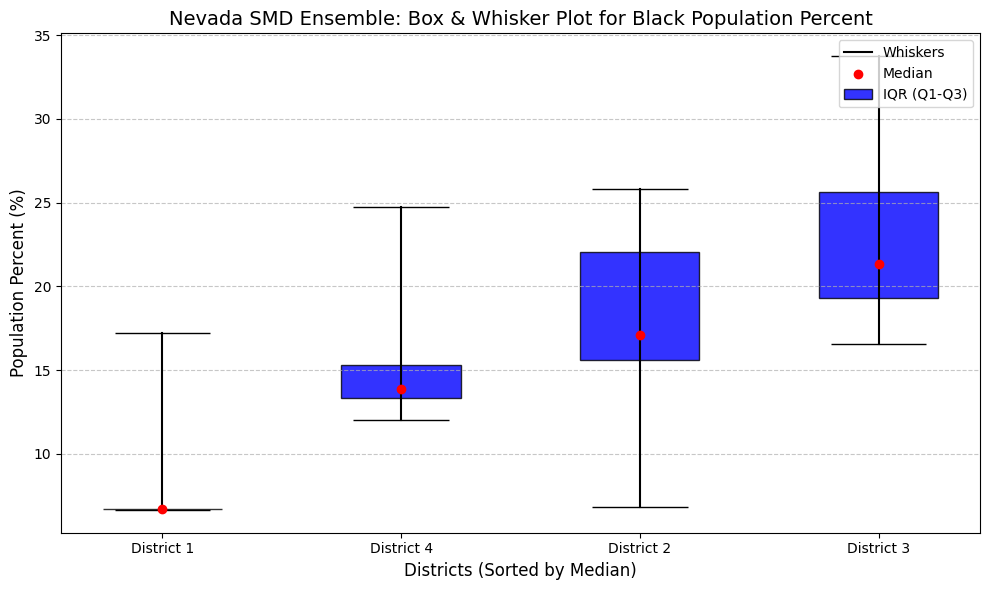

In [338]:

shp_path = 'nv_2020_final/nv_2020_final.shp'
shapefile = gpd.read_file(shp_path)
shapefile = shapefile.to_crs(epsg=4326)
shapefile['ASN'] = shapefile['ASN'].fillna(0)
shapefile['AFAM'] = shapefile['AFAM'].fillna(0)
shapefile['WHT'] = shapefile['WHT'].fillna(0)
shapefile['HPAC'] = shapefile['HPAC'].fillna(0)

with open('random_district0.json', 'r') as file:
    raw_data_district0 = json.load(file)
with open('random_district2.json', 'r') as file:
    raw_data_district2 = json.load(file)
with open('random_district4.json', 'r') as file:
    raw_data_district4 = json.load(file)
with open('random_district100.json', 'r') as file:
    raw_data_district100 = json.load(file)

nv_data = {
    "fips": "NV",
    "electionType": "SMD",
    "totalDistricts": 0,
    "democratAvgVoteShare": 0,
    "democratAvgSeatShare": 0,
    "republicanAvgVoteShare": 0,
    "republicanAvgSeatShare": 0,
    "barData": []

    }
nv_demographic_data = {
    "fips": "NV",
    "electionType": "SMD",
    "totalDistricts": 4,
    "barData": []

    }
nv_vote_seat_share_data = {
    "fips": "NV",
    "electionType": "SMD",
    "totalDistricts": 0,
    "symmetry": 0.5,
    "bias": 2.5,
    "responsiveness": 0.75,
    "barData": []

    }
nv_box_ans_whisker_data = {
    "fips": "NV",
    "electionType": "SMD",
    "totalDistricts": 4,
    "boxes": []

    }
races = ["white", "black", "asian", "hispanic"]

'''
election_result_collection(raw_data_district0, nv_data)
election_result_collection(raw_data_district2, nv_data)
election_result_collection(raw_data_district4, nv_data)
election_result_collection(raw_data_district100, nv_data)
collect_district_plan_demographic(raw_data_district0,shapefile ,nv_demographic_data)
collect_district_plan_demographic(raw_data_district2,shapefile ,nv_demographic_data)
collect_district_plan_demographic(raw_data_district4,shapefile ,nv_demographic_data)
collect_district_plan_demographic(raw_data_district100,shapefile ,nv_demographic_data)
calculate_opportunity_SMD(nv_demographic_data, nv_data, 'hispanic', 0.50)
nv_data
file_path = 'nv_ensemble_bar.json'
with open(file_path, 'w') as json_file:
    json.dump(nv_data, json_file, indent=4)

collect_vote_seat_share_metrics(raw_data_district0, nv_vote_seat_share_data)
collect_vote_seat_share_metrics(raw_data_district2, nv_vote_seat_share_data)
collect_vote_seat_share_metrics(raw_data_district4, nv_vote_seat_share_data)
collect_vote_seat_share_metrics(raw_data_district100, nv_vote_seat_share_data)
calculate_annotation_for_vote_seat_share(nv_vote_seat_share_data)
file_path = 'nv_ensemble_vote_seat_share.json'
with open(file_path, 'w') as json_file:
    json.dump(nv_vote_seat_share_data, json_file, indent=4)
#vote_seat_share(nv_vote_seat_share_data,)
'''
collect_district_plan_demographic(raw_data_district0,shapefile ,nv_demographic_data)
collect_box_and_whisker(nv_demographic_data, nv_box_ans_whisker_data, races)
ensembles_box_and_whisker(nv_box_ans_whisker_data, 'black')
#nv_box_ans_whisker_data
